In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import tarfile
import requests
import json
import random
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Preprocessing


In [2]:
# Download and unpack data
# data_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
# response = requests.get(data_url)
# compressed_path = "data/flower_photos.tgz"

# with open(compressed_path, "wb") as compressed_file:
#     compressed_file.write(response.content)

# assert tarfile.is_tarfile(compressed_path) == True, "not a compress file (.tgz)"

# tarfile.open("data/flower_photos.tgz").extractall("data/")

In [2]:
# inspect data and number of images

data_dir = "data/flower_photos/"

with open(data_dir+"file_index.json", "r") as file:
    flowers = json.load(file)

# flowers = {}
# for folder in os.listdir(data_dir):
#     if os.path.isdir(data_dir+folder):
#         flowers[folder] = os.listdir(data_dir+folder)

# with open(data_dir+"file_index.json", "w") as file:
#     file.write(json.dumps(flowers, indent=4))

count_per_flower = list(map(len, flowers.values()))
picture_count = sum(count_per_flower)
list(zip(flowers.keys(), count_per_flower))


[('daisy', 633),
 ('dandelion', 898),
 ('roses', 641),
 ('sunflowers', 699),
 ('tulips', 799)]

In [3]:
# test/train/validation split 80/15/5
# train_set = {}
# test_set = {}
# validation_set = {}

# for folder in flowers.keys():
#     test_split = round(len(flowers[folder])*0.20)
#     validation_split = round(len(flowers[folder])*0.05)

#     random.shuffle(flowers[folder])
#     test_set[folder] = set(flowers[folder][:test_split])
#     validation_set[folder] = set(flowers[folder][test_split:test_split+validation_split])
#     train_set[folder] = set(flowers[folder][test_split+validation_split:])   

validation_set = set(os.listdir(data_dir+"validation/"))

In [5]:
# # move into train/test/validation directories for ImageDataGenerator

# os.mkdir(data_dir+"train")
# for folder in train_set.keys():
#     os.mkdir(data_dir+"train/"+folder)
#     for file in train_set[folder]:
#         try:
#             os.rename(data_dir+folder+"/"+file, data_dir+f"train/{folder}/"+file)
#         except Exception as e:
#             with open(data_dir+"error_log.txt", "a") as error_log:
#                 # error_log.write(f'ERROR: {data_dir+folder+"/"+file} --> {data_dir+f"train/{folder}/"+file}\n')
#                 error_log.write(str(e)+"\n")

# os.mkdir(data_dir+"test")
# for folder in test_set.keys():
#     os.mkdir(data_dir+"test/"+folder)
#     for file in test_set[folder]:
#         try:
#             os.rename(data_dir+folder+"/"+file, data_dir+f"test/{folder}/"+file)
#         except Exception as e:
#             with open(data_dir+"error_log.txt", "a") as error_log:
#                 # error_log.write(f'ERROR: {data_dir+folder+"/"+file} --> {data_dir+f"test/{folder}/"+file}\n')
#                 error_log.write(str(e)+"\n")

# os.mkdir(data_dir+"validation")
# for folder in validation_set.keys():
#     for file in validation_set[folder]:
#         try:
#             os.rename(data_dir+folder+"/"+file, data_dir+"validation/"+file)
#         except Exception as e:
#             with open(data_dir+"error_log.txt", "a") as error_log:
#                 # error_log.write(f'ERROR: {data_dir+folder+"/"+file} --> {data_dir+"validation/"+file}\n')
#                 error_log.write(str(e)+"\n")

In [4]:
# create test and train generators
train_dir = data_dir+"train/"
test_dir = data_dir+"test/"
batch = 32
img_height = 180
img_width = 180
img_size = (img_height, img_width)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size=batch, class_mode='binary', target_size=img_size, shuffle=True)   
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=batch, class_mode='binary', target_size=img_size, shuffle=True)  

# datagen.shape = [X,Y] 
# X =  [Batches]
# Batches = [180x180x3]  


Found 2751 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


# Model


In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [6]:
# Set up callbacks
class AccuracyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.9): 
      print("\nReached 90% accuracy. Cancelling training!")
      self.model.stop_training = True

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=data_dir+"model_weights/", monitor="val_acc", mode="max", save_best_only=True)
lr_adjustment = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', patience=5, cooldown=10, verbose=1, min_lr=1e-05)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2, mode='auto', baseline=None, restore_best_weights=True)
accuracy_condition = AccuracyCallback()

train_steps_per_epoch = train_generator.samples/batch
val_steps_per_epoch = test_generator.samples/batch


In [12]:
def acc_loss_plots(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure()
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation Loss')
    plt.legend()

    return (acc, val_acc), (loss, val_loss), epochs

### _3xConv2D + Dense(128)_ 

run for more epochs to get higher accuracy

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(len(flowers.keys()), activation="sigmoid")
])

In [8]:
# compile model with ADAM
model.compile(optimizer = "adam", 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy']
)


# train model 
history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    steps_per_epoch=train_steps_per_epoch, 
                    validation_steps=val_steps_per_epoch, 
                    epochs=20, 
                    verbose=1,
                    callbacks=[
                        # accuracy_condition, 
                        checkpoint_callback
                    ]
) 

  ...
    to  
  ['...']
Train for 85.96875 steps, validate for 22.96875 steps
Epoch 1/20
85/85 [============================>.] - ETA: 0s - loss: 1.3758 - accuracy: 0.3733
Epoch 00001: saving model to data/flower_photos/model_weights/
86/85 [==============================] - 38s 437ms/step - loss: 1.3760 - accuracy: 0.3740 - val_loss: 1.1995 - val_accuracy: 0.4884
Epoch 2/20
85/85 [============================>.] - ETA: 0s - loss: 1.1679 - accuracy: 0.4755
Epoch 00002: saving model to data/flower_photos/model_weights/
86/85 [==============================] - 25s 291ms/step - loss: 1.1700 - accuracy: 0.4751 - val_loss: 1.1253 - val_accuracy: 0.5129
Epoch 3/20
85/85 [============================>.] - ETA: 0s - loss: 1.1220 - accuracy: 0.5149
Epoch 00003: saving model to data/flower_photos/model_weights/
86/85 [==============================] - 26s 300ms/step - loss: 1.1246 - accuracy: 0.5144 - val_loss: 1.1310 - val_accuracy: 0.5252
Epoch 4/20
85/85 [============================>.] - ET

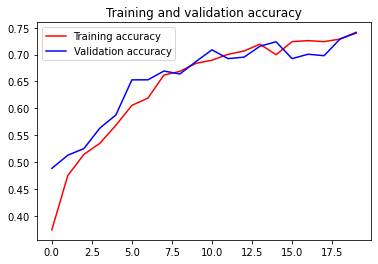

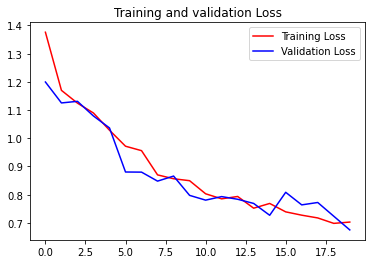

In [10]:
(acc, val_acc), (loss, val_loss), epochs = acc_loss_plots(history)

In [12]:
# os.mkdir(data_dir+"model")
# model.save(data_dir+"model/3Conv2D_Dense128_20Epochs/")

INFO:tensorflow:Assets written to: data/flower_photos/model/3Conv2D_Dense128_20Epochs/assets


In [14]:
# train model for another 20 epochs
# model = tf.keras.load_model(data_dir+"model/3Conv2D_Dense128_20Epochs/")
history2 = model.fit(train_generator, 
                    validation_data=test_generator, 
                    steps_per_epoch=train_steps_per_epoch, 
                    validation_steps=val_steps_per_epoch, 
                    epochs=40,
                    initial_epoch=21,
                    verbose=1,
                    callbacks=[
                        checkpoint_callback
                    ]
) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 85.96875 steps, validate for 22.96875 steps
Epoch 22/40
85/85 [============================>.] - ETA: 0s - loss: 0.6921 - accuracy: 0.7341
Epoch 00022: saving model to data/flower_photos/model_weights/
86/85 [==============================] - 23s 267ms/step - loss: 0.6921 - accuracy: 0.7343 - val_loss: 0.6932 - val_accuracy: 0.7238
Epoch 23/40
85/85 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.7613
Epoch 00023: saving model to data/flower_photos/model_weights/
86/85 [==============================] - 24s 280ms/step - loss: 0.6591 - accuracy: 0.7608 - val_loss: 0.7015 - val_accuracy: 0.7415
Epoch 24/40
85/85 [============================>.] - ETA: 0s - loss: 0.6710 - accuracy: 0.7422
Epoch 00024: saving model to data/flower_photos/model_weights/
86/85 [==============================] - 24s 279ms/step - loss: 0.6711 - accuracy: 0.7419 - val_loss: 0.6907 - val_accuracy: 0.7429
Epoch 25/40
85/85 [=======

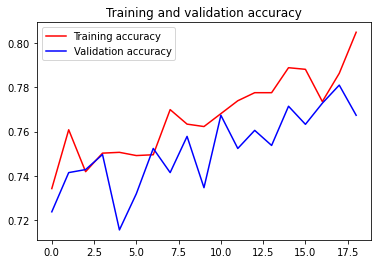

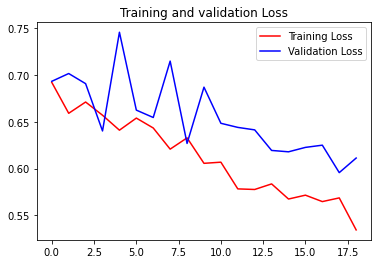

In [16]:
(acc, val_acc), (loss, val_loss), epochs = acc_loss_plots(history2)

In [17]:
# train model for another 20 epochs
# model = tf.keras.load_model(data_dir+"model/3Conv2D_Dense128_20Epochs/")
history3 = model.fit(train_generator, 
                    validation_data=test_generator, 
                    steps_per_epoch=train_steps_per_epoch, 
                    validation_steps=val_steps_per_epoch, 
                    epochs=60,
                    initial_epoch=40,
                    verbose=1,
                    callbacks=[checkpoint_callback]
) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 85.96875 steps, validate for 22.96875 steps
Epoch 41/60
85/85 [============================>.] - ETA: 0s - loss: 0.5383 - accuracy: 0.7974
Epoch 00041: saving model to data/flower_photos/model_weights/
86/85 [==============================] - 23s 268ms/step - loss: 0.5376 - accuracy: 0.7975 - val_loss: 0.6191 - val_accuracy: 0.7714
Epoch 42/60
85/85 [============================>.] - ETA: 0s - loss: 0.5480 - accuracy: 0.7860
Epoch 00042: saving model to data/flower_photos/model_weights/
86/85 [==============================] - 25s 289ms/step - loss: 0.5481 - accuracy: 0.7859 - val_loss: 0.6151 - val_accuracy: 0.7741
Epoch 43/60
85/85 [============================>.] - ETA: 0s - loss: 0.5363 - accuracy: 0.7926
Epoch 00043: saving model to data/flower_photos/model_weights/
86/85 [==============================] - 24s 281ms/step - loss: 0.5347 - accuracy: 0.7932 - val_loss: 0.6184 - val_accuracy: 0.7714
Epoch 44/60
85/85 [=======

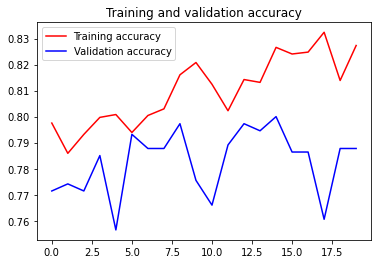

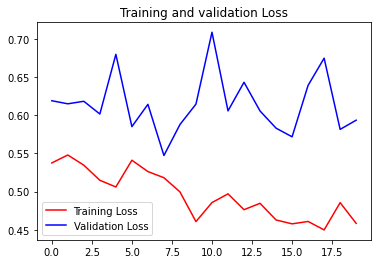

In [18]:
(acc, val_acc), (loss, val_loss), epochs = acc_loss_plots(history3)
# val_acc seems to plateau at 78%

We can see some good improvements but we would like to improve val_acc beyond 70%

### _5xConv2D + Dense(512)_

max(val_acc) ~ 84%


In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
model = tf.keras.models.Sequential([
    # convolutions
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(*img_size,3)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten
    tf.keras.layers.Flatten(),
    # Hidden layers
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    # Dropout
    tf.keras.layers.Dropout(0.2), 
    # Output layer
    tf.keras.layers.Dense(len(flowers.keys()), activation="sigmoid")
])

In [9]:
# compile model with ADAM
model.compile(optimizer = "adam", 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])


# train model 
history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    steps_per_epoch=train_steps_per_epoch, 
                    validation_steps=val_steps_per_epoch, 
                    epochs=60, 
                    verbose=1,
                    callbacks=[
                        accuracy_condition, 
                        checkpoint_callback
                    ]
) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 85.96875 steps, validate for 22.96875 steps
Epoch 1/60
86/85 [==============================] - 26s 302ms/step - loss: 1.2776 - accuracy: 0.4264 - val_loss: 2.4960 - val_accuracy: 0.2367
Epoch 2/60
86/85 [==============================] - 24s 278ms/step - loss: 1.1681 - accuracy: 0.4835 - val_loss: 1.7125 - val_accuracy: 0.3810
Epoch 3/60
86/85 [==============================] - 24s 282ms/step - loss: 1.0870 - accuracy: 0.5482 - val_loss: 1.1535 - val_accuracy: 0.4912
Epoch 4/60
86/85 [==============================] - 24s 274ms/step - loss: 1.0450 - accuracy: 0.5725 - val_loss: 1.0660 - val_accuracy: 0.5755
Epoch 5/60
86/85 [==============================] - 25s 287ms/step - loss: 0.9859 - accuracy: 0.5889 - val_loss: 0.9439 - val_accuracy: 0.5850
Epoch 6/60
86/85 [==============================] - 24s 281ms/step - loss: 0.9590 - accuracy: 0.6034 - val_loss: 0.9264 - val_accuracy: 0.6190
Epoch 7/60
86/85 [====================

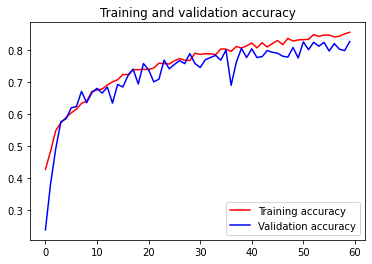

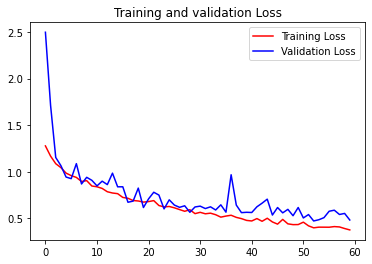

In [13]:
(acc, val_acc),(loss, val_loss), epochs = acc_loss_plots(history)

In [16]:
model.save(data_dir+"model/5Conv2D_Dense512_60Epochs/")
model.save_weights(data_dir+"model_weights/")

INFO:tensorflow:Assets written to: data/flower_photos/model/5Conv2D_Dense512_60Epochs/assets


In [59]:
evaluation = model.evaluate(test_generator, verbose=0)

  ...
    to  
  ['...']


In [61]:
evaluation

[0.482591503340265, 0.8272109]

# Predict 

{0.11909583: 'daisy', 0.3703405: 'dandelion', 12.40828: 'roses', 0.030299798: 'sunflowers', 28.151665: 'tulips'}
tulips


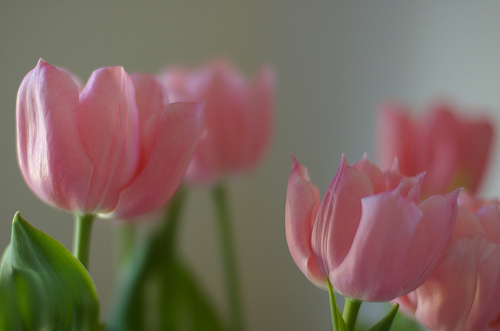

In [58]:
OOS_test_path = data_dir+"validation/"
img = PIL.Image.open(OOS_test_path+random.choice(list(validation_set)))
predict_input = np.array(img.resize(img_size).getdata())/255

prediction = model.predict(predict_input.reshape(1,img_width, img_height,3))

prediction_output = dict(zip(*prediction*100,flowers.keys()))

print(prediction_output)

print(prediction_output[max(prediction_output)])
img

# Findings

- loss doesnt move --> change loss function or learning rate (it could be that model is not designed correctly)
- accuracy goes up while loss is stagnant --> use dropout or augmentation to avoid overfitting
- all ouputs from the output layer are 1 --> normalise each layer and check layer output magnitudes to see if you have NaNs or 0s
- loss is going down but validation loss is going up --> add augmentations or dropout
- acc is going up but val_acc is going down (overfitting) --> add augmentation, add more data, last reason is model complexity is too high
- if labels are one hot encoded --> use categorical_cross_entropy
- if labels are integers --> use sparse_categorical_cross_entropy



# Appendix

Other tried models

### _InceptionV3_

In [45]:
# load weights from pre_trained model
inceptionv3_model = InceptionV3(input_shape = (img_width, img_height, 3), 
                                include_top = False, # the model has a dense layer at the top which we dont want to include
                                weights = "imagenet") 

for layer in inceptionv3_model.layers:
    layer.trainable = False

In [9]:
# inceptionv3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 89, 89, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 89, 89, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 89, 89, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [46]:
# choose a layer as input to our model
last_layer = inceptionv3_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 9, 9, 768)


### _InceptionV3-Mixed7 + Dense(1024)_

The model is too complex for the number of datapoints that we have and overfits. max(val_acc) ~ 82%

In [47]:
# Add our model on top

# Flatten the output layer to 1 dimension
flatten_layer = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
my_dense = tf.keras.layers.Dense(1024, activation='relu')(flatten_layer)
# 
normalised = tf.keras.layers.BatchNormalization()(my_dense)
# Add a dropout rate of 0.2
dropout_layer = tf.keras.layers.Dropout(0.2)(normalised)                  
# Add a final sigmoid layer for classification
my_output_layer = tf.keras.layers.Dense(len(flowers.keys()), activation='softmax')(dropout_layer)

model = tf.keras.Model(inceptionv3_model.input, my_output_layer)

In [48]:
# compile model with ADAM
model.compile(optimizer = "adam", 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])


# train model 
history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    steps_per_epoch=train_steps_per_epoch, 
                    validation_steps=val_steps_per_epoch, 
                    epochs=60, 
                    verbose=1,
                    callbacks=[accuracy_condition, 
                                checkpoint_callback
                            ]
) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 85.96875 steps, validate for 22.96875 steps
Epoch 1/60
86/85 [==============================] - 41s 475ms/step - loss: 1.0613 - accuracy: 0.6830 - val_loss: 0.7900 - val_accuracy: 0.7932
Epoch 2/60
86/85 [==============================] - 26s 305ms/step - loss: 0.6212 - accuracy: 0.7892 - val_loss: 1.0044 - val_accuracy: 0.7497
Epoch 3/60
86/85 [==============================] - 25s 290ms/step - loss: 0.5060 - accuracy: 0.8208 - val_loss: 0.6634 - val_accuracy: 0.8136
Epoch 4/60
86/85 [==============================] - 24s 281ms/step - loss: 0.4816 - accuracy: 0.8372 - val_loss: 0.6996 - val_accuracy: 0.8122
Epoch 5/60
86/85 [==============================] - 24s 285ms/step - loss: 0.4333 - accuracy: 0.8539 - val_loss: 1.0341 - val_accuracy: 0.7524
Epoch 6/60
86/85 [==============================] - 24s 275ms/step - loss: 0.4189 - accuracy: 0.8561 - val_loss: 1.0590 - val_accuracy: 0.7619
Epoch 7/60
86/85 [====================

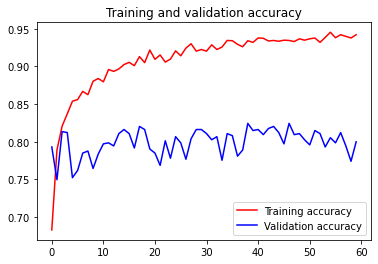

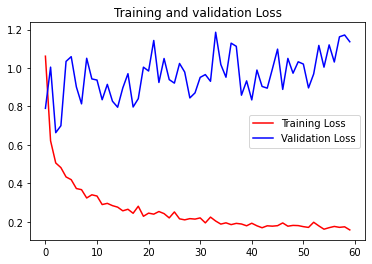

In [49]:
(acc, val_acc), (loss, val_loss), epochs = acc_loss_plots(history)

### _InceptionV3-Mixed1 + Dense(1024)_

max(val_acc) ~ 70%

In [51]:
# choose a layer as input to our model
last_layer = inceptionv3_model.get_layer('mixed1')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Add our model on top
# Flatten the output layer to 1 dimension
flatten_layer = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
my_dense = tf.keras.layers.Dense(1024, activation='relu')(flatten_layer)
normalised = tf.keras.layers.BatchNormalization()(my_dense)
# Add a dropout rate of 0.2
dropout_layer = tf.keras.layers.Dropout(0.2)(normalised)                  
# Add a final sigmoid layer for classification
my_output_layer = tf.keras.layers.Dense(len(flowers.keys()), activation='softmax')(dropout_layer)

model = tf.keras.Model(inceptionv3_model.input, my_output_layer)

last layer output shape:  (None, 20, 20, 288)


In [52]:
# compile model with ADAM
model.compile(optimizer = "adam", 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])


# train model 
history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    steps_per_epoch=train_steps_per_epoch, 
                    validation_steps=val_steps_per_epoch, 
                    epochs=40, 
                    verbose=1,
                    callbacks=[accuracy_condition, 
                                checkpoint_callback
                            ]
) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 85.96875 steps, validate for 22.96875 steps
Epoch 1/40
86/85 [==============================] - 28s 321ms/step - loss: 1.4041 - accuracy: 0.5914 - val_loss: 7.2913 - val_accuracy: 0.3986
Epoch 2/40
86/85 [==============================] - 28s 320ms/step - loss: 0.8225 - accuracy: 0.6925 - val_loss: 2.5651 - val_accuracy: 0.4639
Epoch 3/40
86/85 [==============================] - 25s 293ms/step - loss: 0.7921 - accuracy: 0.7048 - val_loss: 1.4316 - val_accuracy: 0.5701
Epoch 4/40
86/85 [==============================] - 26s 301ms/step - loss: 0.7396 - accuracy: 0.7263 - val_loss: 2.1125 - val_accuracy: 0.4871
Epoch 5/40
86/85 [==============================] - 27s 317ms/step - loss: 0.7131 - accuracy: 0.7394 - val_loss: 1.2459 - val_accuracy: 0.6204
Epoch 6/40
86/85 [==============================] - 25s 292ms/step - loss: 0.6686 - accuracy: 0.7474 - val_loss: 1.3703 - val_accuracy: 0.6095
Epoch 7/40
86/85 [====================

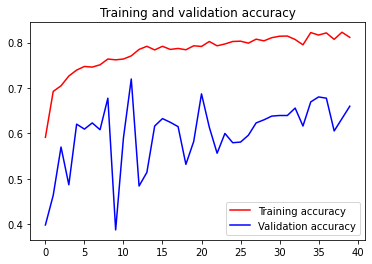

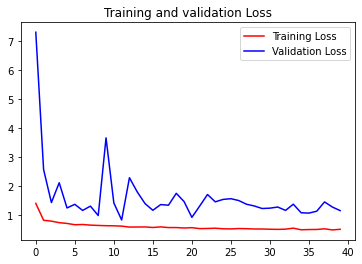

In [53]:
(acc, val_acc), (loss, val_loss), epochs = acc_loss_plots(history)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 85.96875 steps, validate for 22.96875 steps
Epoch 41/60
86/85 [==============================] - 26s 301ms/step - loss: 0.4983 - accuracy: 0.8113 - val_loss: 1.6044 - val_accuracy: 0.5633
Epoch 42/60
86/85 [==============================] - 24s 276ms/step - loss: 0.4999 - accuracy: 0.8193 - val_loss: 0.9254 - val_accuracy: 0.7116
Epoch 43/60
86/85 [==============================] - 26s 305ms/step - loss: 0.4836 - accuracy: 0.8270 - val_loss: 1.3529 - val_accuracy: 0.6299
Epoch 44/60
86/85 [==============================] - 27s 319ms/step - loss: 0.4904 - accuracy: 0.8128 - val_loss: 1.4657 - val_accuracy: 0.6041
Epoch 45/60
86/85 [==============================] - 27s 316ms/step - loss: 0.5002 - accuracy: 0.8106 - val_loss: 1.5223 - val_accuracy: 0.5769
Epoch 46/60
86/85 [==============================] - 26s 297ms/step - loss: 0.4812 - accuracy: 0.8186 - val_loss: 1.0864 - val_accuracy: 0.6898
Epoch 47/60
86/85 [=============

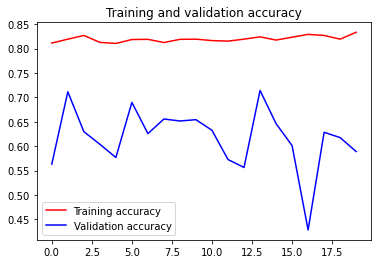

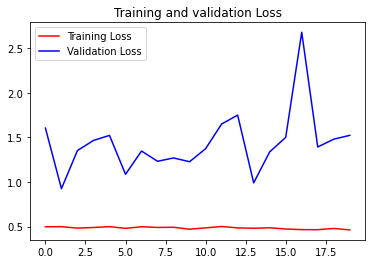

In [55]:
# continue to train model 
history2 = model.fit(train_generator, 
                    validation_data=test_generator, 
                    steps_per_epoch=train_steps_per_epoch, 
                    validation_steps=val_steps_per_epoch, 
                    epochs=60,
                    initial_epoch = 40,
                    verbose=1,
                    callbacks=[accuracy_condition, 
                                checkpoint_callback
                            ]
) 
(acc, val_acc), (loss, val_loss), epochs = acc_loss_plots(history2)